 Use Autoencoder to implement anomaly detection. Build the model by using:
 
a. Import required libraries

b. Upload / access the dataset

c. Encoder converts it into latent representation

d. Decoder networks convert it back to the original input

e. Compile the models with Optimizer, Loss, and Evaluation Metrics

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

C:\python37\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [5]:
df = pd.read_csv("creditcard.csv")

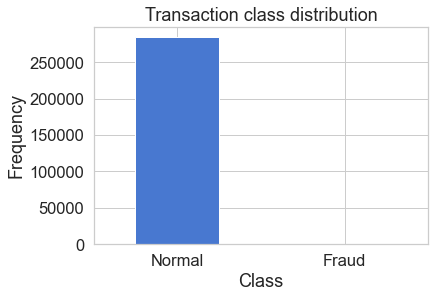

In [7]:

count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [10]:

from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

In [11]:
data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [12]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [13]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [14]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

In [15]:
nb_epoch = 10
batch_size = 32
early_stop = tf.keras.callbacks. EarlyStopping( monitor= 'val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min', 
                                               restore_best_weights=True)

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, early_stop]).history

Epoch 1/10
7106/7108 [============================>.] - ETA: 0s - loss: 0.8033 - accuracy: 0.5818

C:\python37\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7108/7108 [==============================] - 65s 8ms/step - loss: 0.8033 - accuracy: 0.5819 - val_loss: 0.7731 - val_accuracy: 0.6633
Epoch 2/10
7108/7108 [==============================] - 58s 8ms/step - loss: 0.7308 - accuracy: 0.6829 - val_loss: 0.7528 - val_accuracy: 0.6927
Epoch 3/10
7108/7108 [==============================] - 62s 9ms/step - loss: 0.7179 - accuracy: 0.6977 - val_loss: 0.7454 - val_accuracy: 0.7016
Epoch 4/10
7108/7108 [==============================] - 57s 8ms/step - loss: 0.7127 - accuracy: 0.7006 - val_loss: 0.7428 - val_accuracy: 0.7030
Epoch 5/10
7108/7108 [==============================] - 58s 8ms/step - loss: 0.7099 - accuracy: 0.7024 - val_loss: 0.7416 - val_accuracy: 0.6978
Epoch 6/10
7108/7108 [==============================] - 57s 8ms/step - loss: 0.7075 - accuracy: 0.7045 - val_loss: 0.7390 - val_accuracy: 0.7036
Epoch 7/10
7108/7108 [==============================] - 57s 8ms/step - loss: 0.7060 - accuracy: 0.7051 - val_loss: 0.7400 - val_accuracy: 0.7

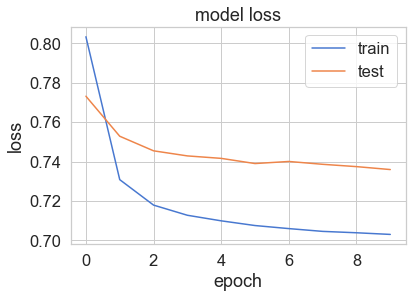

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [17]:
predictions = autoencoder.predict(X_test)

1781/1781 [==============================] - 10s 5ms/step


In [18]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
 'true_class': y_test})

In [19]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.735157,0.001720
std,3.481664,0.041443
min,0.044708,0.000000
25%,0.240433,0.000000
50%,0.391961,0.000000
75%,0.627894,0.000000
max,272.045854,1.000000


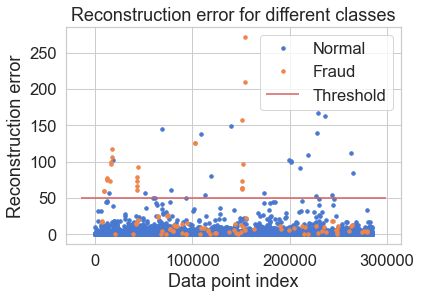

In [21]:
threshold = 50
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [22]:
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score

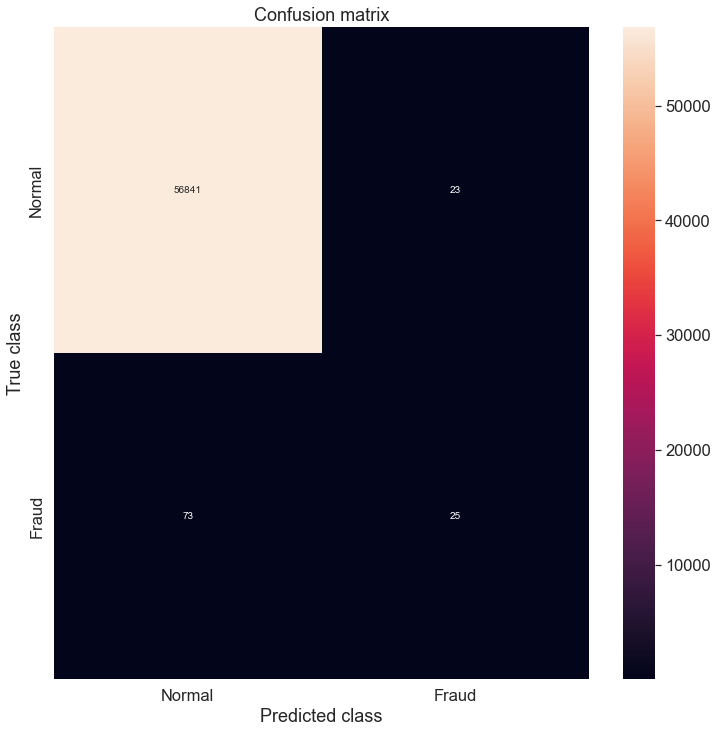

In [23]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [24]:
error_df['pred'] = y_pred

In [25]:
print("Accuracy:",accuracy_score (error_df['true_class'],error_df['pred'])) 
print("Recall:",recall_score(error_df['true_class'],error_df['pred']))
print("Precision:",precision_score(error_df['true_class'],error_df['pred']))

Accuracy: 0.9983146659176293
Recall: 0.25510204081632654
Precision: 0.5208333333333334
